In [1]:
!pip install yfinance

In [9]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt
import requests
import re
import os
import pyarrow.parquet as pq

## Question 1: IPO Filings Web Scraping and Data Processing
What's the total sum ($m) of 2023 filings that happened on Fridays?

Re-use the [Code Snippet 1] example to get the data from web for this endpoint: https://stockanalysis.com/ipos/filings/ Convert the 'Filing Date' to datetime(), 'Shares Offered' to float64 (if '-' is encountered, populate with NaNs). Define a new field 'Avg_price' based on the "Price Range", which equals to NaN if no price is specified, to the price (if only one number is provided), or to the average of 2 prices (if a range is given). You may be inspired by the function extract_numbers() in [Code Snippet 4], or you can write your own function to "parse" a string. Define a column "Shares_offered_value", which equals to "Shares Offered" * "Avg_price" (when both columns are defined; otherwise, it's NaN)

Find the total sum in $m (millions of USD, closest INTEGER number) for all filings during 2023, which happened on Fridays (Date.dt.dayofweek()==4). You should see 32 records in total, 25 of it is not null.

(additional: you can read about S-1 IPO filing to understand the context)

In [4]:
# Function to parse price ranges and compute average
def parse_price_range(price_range):
    if pd.isna(price_range):
        return np.nan
    numbers = list(map(float, re.findall(r"\d+\.\d+", price_range)))
    if len(numbers) == 0:
        return np.nan
    elif len(numbers) == 1:
        return numbers[0]
    else:
        return sum(numbers) / len(numbers)

# Set headers for the HTTP request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

# Specify the URL to scrape
url = "https://stockanalysis.com/ipos/filings/"

# Send the request and get the response
response = requests.get(url, headers=headers)

# Parse the HTML content and extract the table
ipo_dfs = pd.read_html(response.text)
ipos = ipo_dfs[0]

# Data cleaning and transformations
ipos['Filing Date'] = pd.to_datetime(ipos['Filing Date'])
ipos['Shares Offered'] = ipos['Shares Offered'].replace('-', np.nan).astype(float)
ipos['Avg_price'] = ipos['Price Range'].apply(parse_price_range)
ipos['Shares_offered_value'] = ipos['Shares Offered'] * ipos['Avg_price']

# Filtering data for 2023 and Fridays
ipos_2023_fridays = ipos[(ipos['Filing Date'].dt.year == 2023) & (ipos['Filing Date'].dt.dayofweek == 4)]

# Calculating the total sum in millions of USD
total_sum_millions = ipos_2023_fridays['Shares_offered_value'].sum() / 1e6

# Output the result
print("Total sum in millions (USD):", total_sum_millions)
print("Total records on Fridays:", ipos_2023_fridays.shape[0])
print("Non-null records:", ipos_2023_fridays['Shares_offered_value'].notnull().sum())


Total sum in millions (USD): 285.7
Total records on Fridays: 32
Non-null records: 25


## Question 2: IPOs "Fixed days hold" strategy
Find the optimal number of days X (between 1 and 30), where 75% quantile growth is the highest?

Reuse [Code Snippet 1] to retrieve the list of IPOs from 2023 and 2024 (from URLs: https://stockanalysis.com/ipos/2023/ and https://stockanalysis.com/ipos/2024/). Get all OHLCV daily prices for all stocks with an "IPO date" before March 1, 2024 ("< 2024-03-01") - 184 tickers (without 'RYZB'). Please remove 'RYZB', as it is no longer available on Yahoo Finance.

Sometimes you may need to adjust the symbol name (e.g., 'IBAC' on stockanalysis.com -> 'IBACU' on Yahoo Finance) to locate OHLCV prices for all stocks. Some of the tickers like 'DYCQ' and 'LEGT' were on the market less than 30 days (11 and 21 days, respectively). Let's leave them in the dataset; it just means that you couldn't hold them for more days than they were listed.

Let's assume you managed to buy a new stock (listed on IPO) on the first day at the [Adj Close] price]. Your strategy is to hold for exactly X full days (where X is between 1 and 30) and sell at the "Adj. Close" price in X days (e.g., if X=1, you sell on the next day). Find X, when the 75% quantile growth (among 185 investments) is the highest.

HINTs:

You can generate 30 additional columns: growth_future_1d ... growth_future_30d, join that with the table of min_dates (first day when each stock has data on Yahoo Finance), and perform vector operations on the resulting dataset.
You can use the DataFrame.describe() function to get mean, min, max, 25-50-75% quantiles.
Additional:

You can also ensure that the mean and 50th percentile (median) investment returns are negative for most X values, implying a wager for a "lucky" investor who might be in the top 25%.
What's your recommendation: Do you suggest pursuing this strategy for an optimal X?

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

The optimal number of days X is growth_future_28d with a 75% quantile growth of 6.57%.


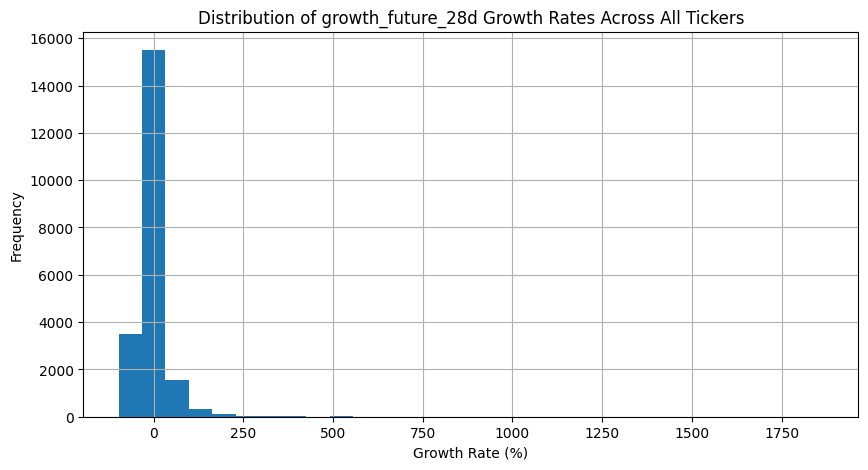

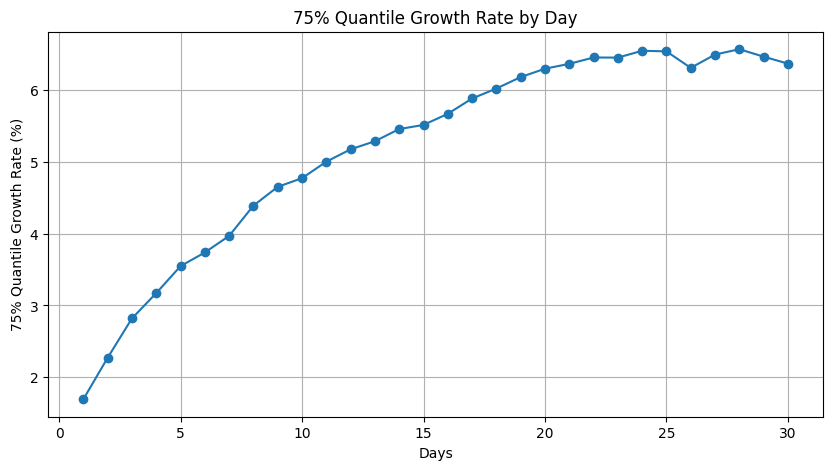

In [5]:
def get_ipo_data(year):
    """Fetch IPO data for a given year."""
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    return pd.read_html(response.text)[0]

def get_prices(symbol, start_date, end_date):
    """Download stock price data."""
    try:
        return yf.download(symbol, start=start_date, end=end_date)
    except Exception as e:
        print(f"Error downloading {symbol}: {e}")
        return None

# Fetch and combine IPO data from 2023 and 2024
ipo_data_2023 = get_ipo_data(2023)
ipo_data_2024 = get_ipo_data(2024)
ipo_data = pd.concat([ipo_data_2023, ipo_data_2024], ignore_index=True)
ipo_data['IPO Date'] = pd.to_datetime(ipo_data['IPO Date'])
filtered_ipo_data = ipo_data[(ipo_data['IPO Date'] < '2024-03-01') & (ipo_data['Symbol'] != 'RYZB')]

# Adjust ticker names if needed and fetch prices
symbol_adjustments = {"PTHR": "PTHRF", "IBAC": "IBACU"}
price_data = {}
for symbol in filtered_ipo_data['Symbol']:
    adjusted_symbol = symbol_adjustments.get(symbol, symbol)
    price_data[adjusted_symbol] = get_prices(adjusted_symbol, "2023-01-01", "2024-03-01")

# Calculate future growth rates for each day from 1 to 30
results = pd.DataFrame()
for symbol, df in price_data.items():
    if df is not None:
        for i in range(1, 31):
            df[f'growth_future_{i}d'] = (df['Adj Close'].shift(-i) / df['Adj Close'] - 1) * 100
        results = pd.concat([results, df[[f'growth_future_{i}d' for i in range(1, 31)]]])

# Analyze growth to find the optimal holding period
quantile_growth = results.quantile(0.75)
optimal_day = quantile_growth.idxmax()
highest_growth = quantile_growth.max()

print(f"The optimal number of days X is {optimal_day} with a 75% quantile growth of {highest_growth:.2f}%.")

# Visualizations
plt.figure(figsize=(10, 5))
results[optimal_day].hist(bins=30)
plt.title(f'Distribution of {optimal_day} Growth Rates Across All Tickers')
plt.xlabel('Growth Rate (%)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, 31), quantile_growth, marker='o')
plt.title('75% Quantile Growth Rate by Day')
plt.xlabel('Days')
plt.ylabel('75% Quantile Growth Rate (%)')
plt.grid(True)
plt.show()

## Question 3: Is Growth Concentrated in the Largest Stocks?
Get the share of days (percentage as int) when Large Stocks outperform (growth_7d - growth over 7 periods back) the Largest stocks?

Reuse [Code Snippet 5] to obtain OHLCV stats for 33 stocks for 10 full years of data (2014-01-01 to 2023-12-31). You'll need to download slightly more data (7 periods before 2014-01-01 to calculate the growth_7d for the first 6 days correctly):

US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS

Now let's add the top 12-22 stocks (as of end-April 2024):

NEW_US = ['TSLA','WMT','XOM','UNH','MA','PG','JNJ','MRK','HD','COST','ORCL']

NEW_EU = ['PRX.AS','CDI.PA','AIR.PA','SU.PA','ETN','SNY','BUD','DTE.DE','ALV.DE','MDT','AI.PA','EL.PA']

NEW_INDIA = ['BAJFINANCE.NS','MARUTI.NS','HCLTECH.NS','TATAMOTORS.NS','SUNPHARMA.NS','ONGC.NS','ADANIENT.NS','ADANIENT.NS','NTPC.NS','KOTAKBANK.NS','TITAN.NS']

LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA

You should be able to obtain stats for 33 LARGEST STOCKS and 32 LARGE STOCKS (from the actual stats on Yahoo Finance)

Calculate growth_7d for every stock and every day. Get the average daily growth_7d for the LARGEST_STOCKS group vs. the LARGE_STOCKS group.

For example, for the first of data you should have:

Date	ticker_category	growth_7d
2014-01-01	LARGE	1.011684
2014-01-01	LARGEST	1.011797
On that day, the LARGEST group was growing faster than LARGE one (new stocks).

Calculate the number of days when the LARGE GROUP (new smaller stocks) outperforms the LARGEST GROUP, divide it by the total number of trading days (which should be 2595 days), and convert it to a percentage (closest INTEGER value). For example, if you find that 1700 out of 2595 days meet this condition, it means that 1700/2595 = 0.655, or approximately 66% of days, the LARGE stocks were growing faster than the LARGEST ones. This suggests that you should consider extending your dataset with more stocks to seek higher growth.



In [7]:
# Define the stocks
LARGEST_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO', 'V', 'JPM', 'NVO', 'MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE', 'IDEXY', 'CDI.PA', 'RELIANCE.NS', 'TCS.NS', 'HDB', 'BHARTIARTL.NS', 'IBN', 'SBIN.NS', 'LICI.NS', 'INFY', 'ITC.NS', 'HINDUNILVR.NS', 'LT.NS']
LARGE_STOCKS = ['TSLA', 'WMT', 'XOM', 'UNH', 'MA', 'PG', 'JNJ', 'MRK', 'HD', 'COST', 'ORCL', 'PRX.AS', 'AIR.PA', 'SU.PA', 'ETN', 'SNY', 'BUD', 'DTE.DE', 'ALV.DE', 'MDT', 'AI.PA', 'EL.PA', 'BAJFINANCE.NS', 'MARUTI.NS', 'HCLTECH.NS', 'TATAMOTORS.NS', 'SUNPHARMA.NS', 'ONGC.NS', 'ADANIENT.NS', 'NTPC.NS', 'KOTAKBANK.NS', 'TITAN.NS']

# Fetch data
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close']

# Calculate 7-day growth for a single series
def calculate_growth(series):
    return series / series.shift(7) - 1

start_date = '2013-12-01'  # Start a week earlier
end_date = '2023-12-31'
all_tickers = LARGEST_STOCKS + LARGE_STOCKS
all_data = {}

# Download data for each ticker and calculate 7-day growth
for ticker in all_tickers:
    print(f"Downloading data for {ticker}")
    data = fetch_data(ticker, start_date, end_date)
    if data is not None and not data.empty:
        growth_data = calculate_growth(data)
        # Filter the growth data to start from 2014-01-01
        filtered_growth_data = growth_data[growth_data.index >= '2014-01-01']
        all_data[ticker] = filtered_growth_data


# Combine all data into a single DataFrame
growth_data = pd.DataFrame(all_data)

# Calculate daily averages for each category
growth_data['LARGEST'] = growth_data[LARGEST_STOCKS].mean(axis=1)
growth_data['LARGE'] = growth_data[LARGE_STOCKS].mean(axis=1)

# Calculate the number of days LARGE outperforms LARGEST
valid_days_data = growth_data.dropna(subset=['LARGE', 'LARGEST'])

# Calculate the number of days LARGE outperforms LARGEST
outperform_days = (valid_days_data['LARGE'] > valid_days_data['LARGEST']).sum()
total_days = valid_days_data.shape[0]  # Total days with valid data for both groups

# Compute the percentage of days LARGE outperforms LARGEST
if total_days > 0:  # Prevent division by zero
    percentage_days = (outperform_days / total_days) * 100
else:
    percentage_days = 0  # No days with valid data

print(f"Percentage of days when LARGE stocks outperformed LARGEST stocks: {percentage_days}%")

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


Percentage of days when LARGE stocks outperformed LARGEST stocks: 46.628131021194605%


## Question 4: Trying Another Technical Indicators strategy
What's the total gross profit (in THOUSANDS of $) you'll get from trading on CCI (no fees assumption)?

First, run the entire Colab to obtain the full DataFrame of data (after [Code Snippet 9]), and truncate it to the last full 10 years of data (2014-01-01 to 2023-12-31). If you encounter any difficulties running the Colab - you can download it using this link.

Let's assume you've learned about the awesome CCI indicator (Commodity Channel Index), and decided to use only it for your operations.

You defined the "defensive" value of a high threshould of 200, and you trade only on Fridays (Date.dt.dayofweek()==4).

That is, every time you see that CCI is >200 for any stock (out of those 33), you'll invest $1000 (each record when CCI>200) at Adj.Close price and hold it for 1 week (5 trading days) in order to sell at the Adj. Close price.

What's the expected gross profit (no fees) that you get in THOUSANDS $ (closest integer value) over many operations in 10 years? One operation calculations: if you invested $1000 and received $1010 in 5 days - you add $10 to gross profit, if you received $980 - add -$20 to gross profit. You need to sum these results over all trades (460 times in 10 years).

Additional:

Add an approximate fees calculation over the 460 trades from this calculator https://www.degiro.ie/fees/calculator (Product:"Shares, USA and Canada;" Amount per transaction: "1000 EUR"; Transactions per year: "460")
are you still profitable on those trades?


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

file_path = '/content/drive/MyDrive/stocks_df_combined_2024_05_01.parquet.brotli'
print(os.path.exists(file_path))
# Load the Parquet file into a DataFrame
try:
    table = pq.read_table(file_path)
    m16 = table.to_pandas()
    print(m16.head())
except Exception as e:
    print(f"Error reading the Parquet file: {e}")

True
       Open      High       Low     Close  Adj Close_x        Volume Ticker  \
0  0.088542  0.101563  0.088542  0.097222     0.060163  1.031789e+09   MSFT   
1  0.097222  0.102431  0.097222  0.100694     0.062311  3.081600e+08   MSFT   
2  0.100694  0.103299  0.100694  0.102431     0.063386  1.331712e+08   MSFT   
3  0.102431  0.103299  0.098958  0.099826     0.061774  6.776640e+07   MSFT   
4  0.099826  0.100694  0.097222  0.098090     0.060700  4.789440e+07   MSFT   

   Year      Month  Weekday  ... growth_brent_oil_7d  growth_brent_oil_30d  \
0  1986 1986-03-01        3  ...                 NaN                   NaN   
1  1986 1986-03-01        4  ...                 NaN                   NaN   
2  1986 1986-03-01        0  ...                 NaN                   NaN   
3  1986 1986-03-01        1  ...                 NaN                   NaN   
4  1986 1986-03-01        2  ...                 NaN                   NaN   

   growth_brent_oil_90d  growth_brent_oil_365d  gro

In [11]:
# Filter data for the last full 10 years
m16['Date'] = pd.to_datetime(m16['Date'])
df = m16[(m16['Date'] >= '2014-01-01') & (m16['Date'] <= '2023-12-31')]

# Calculate trading signals
m16['Signal'] = (m16['cci'] > 200) & (m16['Date'].dt.dayofweek == 4)

m16['Price_in_5_days'] = m16['Adj Close_x'].shift(-5)

# Filter rows where trading happens
trades = m16[m16['Signal']]

# Calculate profits for each trade
trades['Profit'] = (trades['Price_in_5_days'] - trades['Adj Close_x']) / trades['Adj Close_x'] * 1000

# Total gross profit
total_gross_profit = trades['Profit'].sum()

# Convert profit to thousands of dollars
total_gross_profit_k = int(total_gross_profit / 1000)

print(f"Total Gross Profit in Thousands of $: {total_gross_profit_k}")


Total Gross Profit in Thousands of $: 3


<ipython-input-11-8d00c8227bdb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['Profit'] = (trades['Price_in_5_days'] - trades['Adj Close_x']) / trades['Adj Close_x'] * 1000
